In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [2]:
import pickle

# READ
with open('moge/data/LMN_Combined_NoCorr/lmn_n85_m70_l85_type_family_location_node10_d_train.pickle', 'rb') as file:
# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network_biogrid.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.remove_extra_nodes()
#     network.node_list = network.all_nodes
#     node_list = network.node_list

nan_nodes = [n for n in network.G.nodes if type(n) != str]
network.G.remove_nodes_from(nan_nodes)
# network.G.number_of_edges()

In [3]:
# READ edgelists
with open('moge/data/LMN_Combined_NoCorr/lmn_n85_m70_l85_type_family_location_node10_d_test.pickle', 'rb') as file:
    network_test = pickle.load(file)
    
with open('moge/data/LMN_Combined_NoCorr/lmn_n85_m70_l85_type_family_location_node10_d_val.pickle', 'rb') as file:
    network_val = pickle.load(file)

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [4]:
isolates = nx.isolates(network.G)
len([n for n in isolates])

0

# Data Visualization

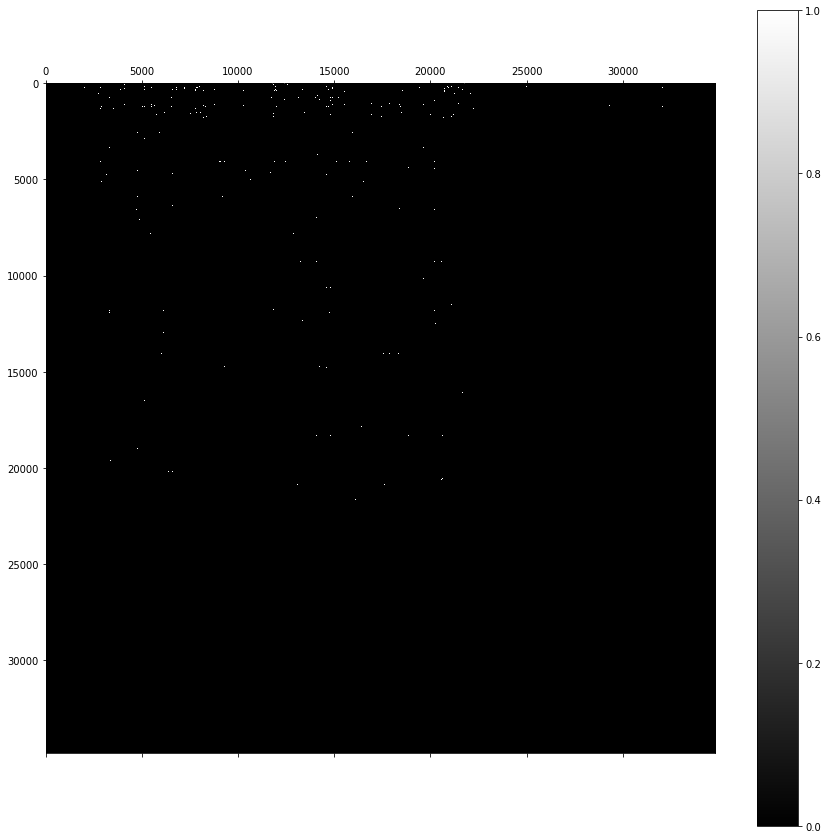

In [4]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

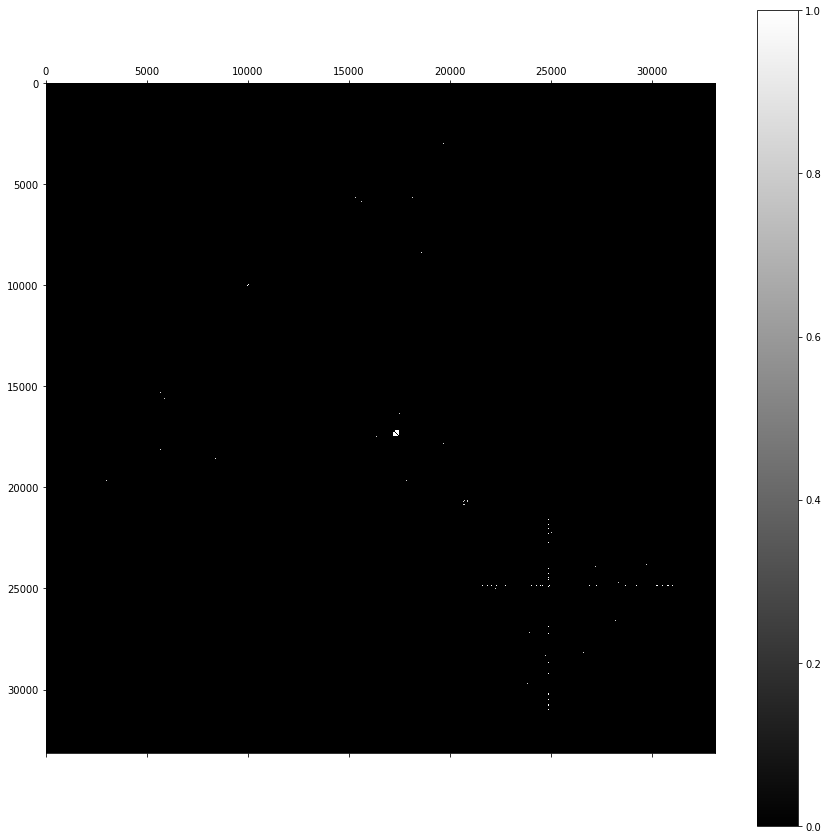

In [5]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

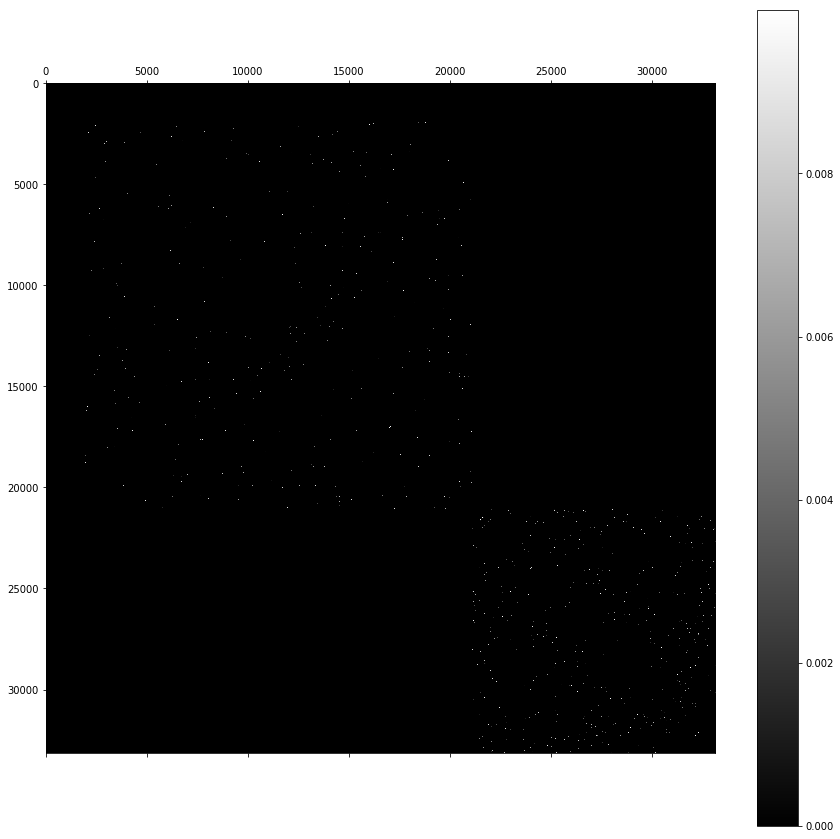

In [6]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

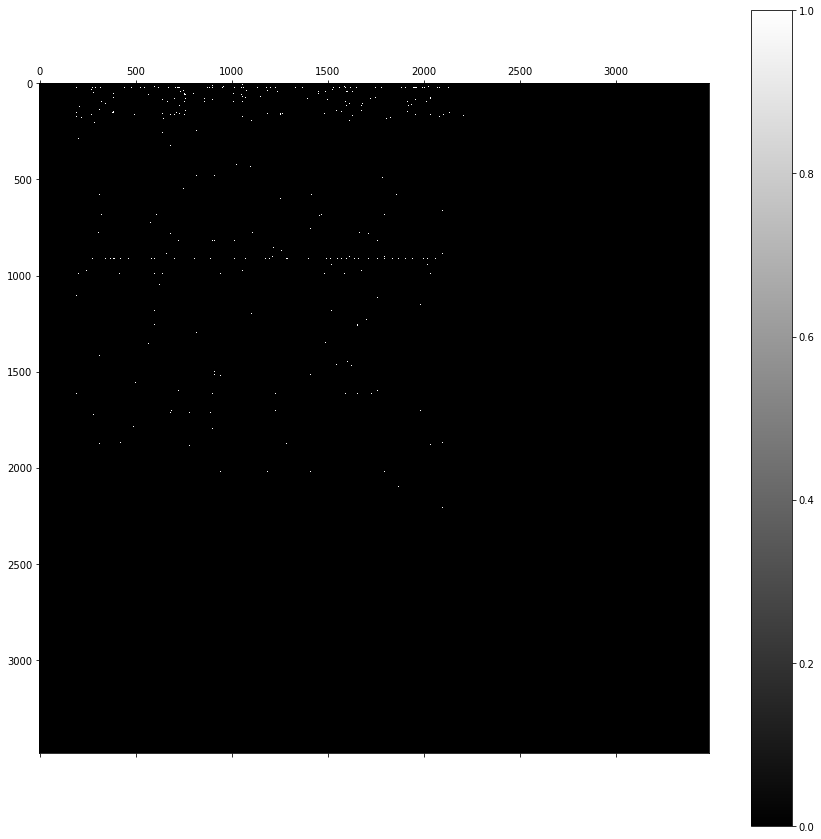

In [5]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [6]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding

siamese = SiameseGraphEmbedding(d=512, batch_size=4096, lr=0.001, epochs=20, negative_sampling_ratio=5.0,
                                 max_length=700, truncating="random", verbose=True)

Using TensorFlow backend.


In [7]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=True, seed=0)

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: 2510
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 513731 , Eu_count: 476424 , En_count: 1049100
Ens_count: 2568655
Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: -28822
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 61491 , Eu_count: 0 , En_count: 0
Ens_count: 61491
conv1d_1 Tensor("conv1d_1/Relu:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
conv1d_2 Tensor("conv1d_2/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
brnn Tensor("bidirecti

Process ForkPoolWorker-196:
Process ForkPoolWorker-205:
Process ForkPoolWorker-206:
Process ForkPoolWorker-207:
Process ForkPoolWorker-201:
Process ForkPoolWorker-200:
Process ForkPoolWorker-193:
Process ForkPoolWorker-194:
Process ForkPoolWorker-198:
Process ForkPoolWorker-195:
Process ForkPoolWorker-203:
Process ForkPoolWorker-208:
Traceback (most recent call last):
Process ForkPoolWorker-202:
Traceback (most recent call last):
Process ForkPoolWorker-204:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jonny/.conda/envs/jonny_conda3/lib/py

KeyboardInterrupt
  File "/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/data_generator.py", line 154, in __getitem__
    X, y = self.__data_generation(edges_batch)
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/data_generator.py", line 154, in __getitem__
    X, y = self.__data_generation(edges_batch)
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
  

  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/numpy/core/numeric.py", line 501, in asarray
    return array(a, dtype, copy=False, order=order)
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/keras_preprocessing/text.py", line 418, in sequences_to_matrix
    counts[j] += 1
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/keras_preprocessing/text.py", line 418, in sequences_to_matrix
    counts[j] += 1
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/keras_preprocessing/text.py", line 416, in sequences_to_matrix
    if j >= num_words:


KeyboardInterrupt: 

# Visualize Embeddings

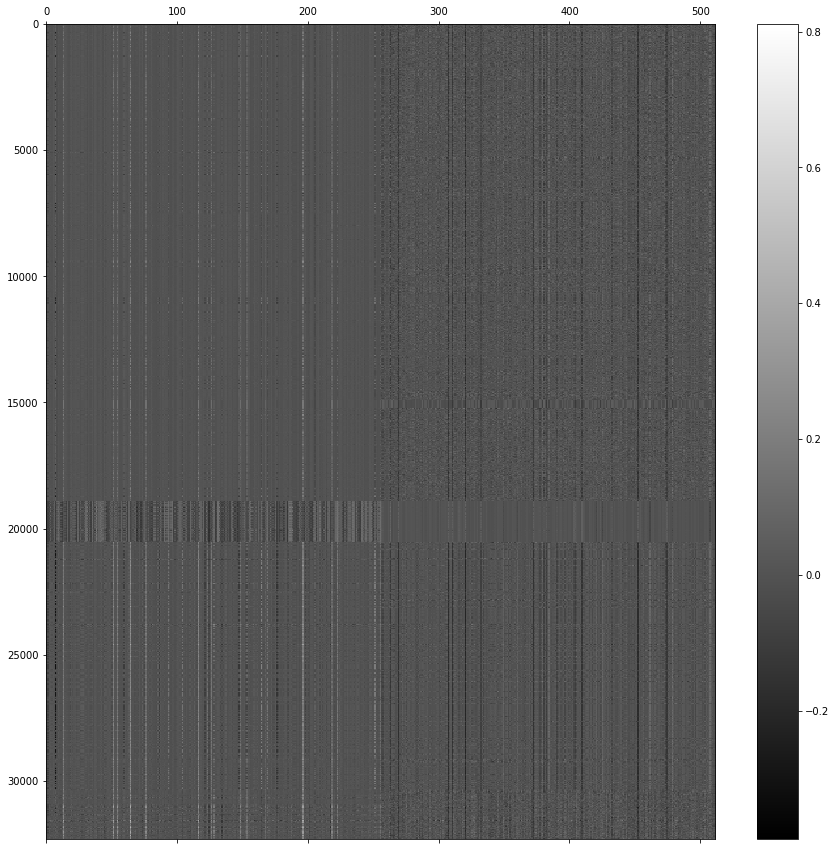

In [8]:
matrix_heatmap(siamese.get_embedding(), aspect='auto')

Embeddings filtered by node list (32269, 512)


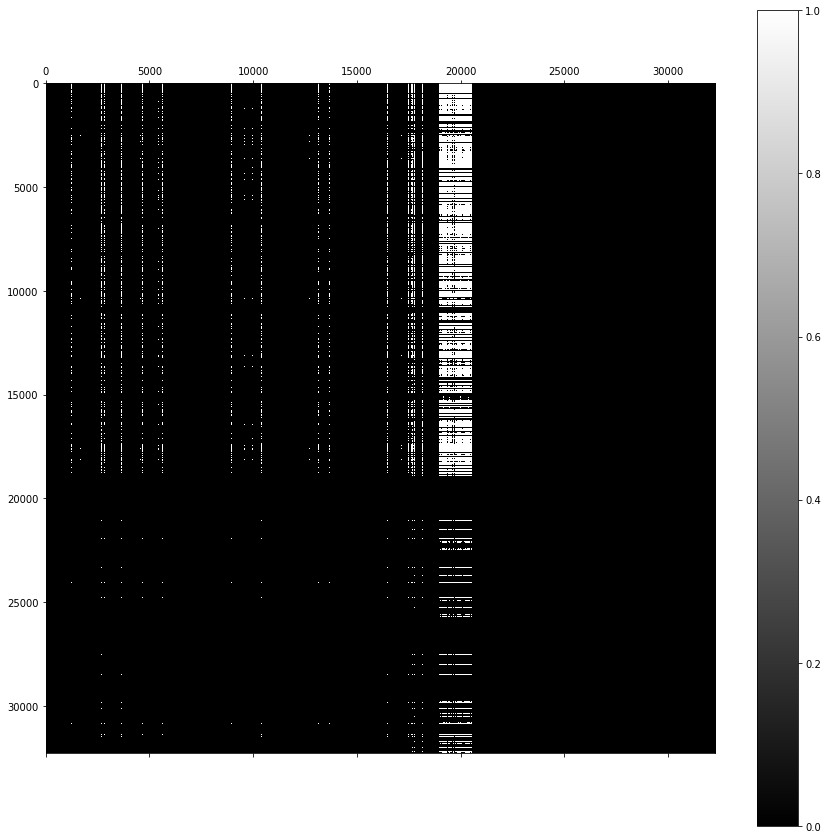

In [9]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", node_l=network.node_list))

Embeddings filtered by node list (3212, 512)


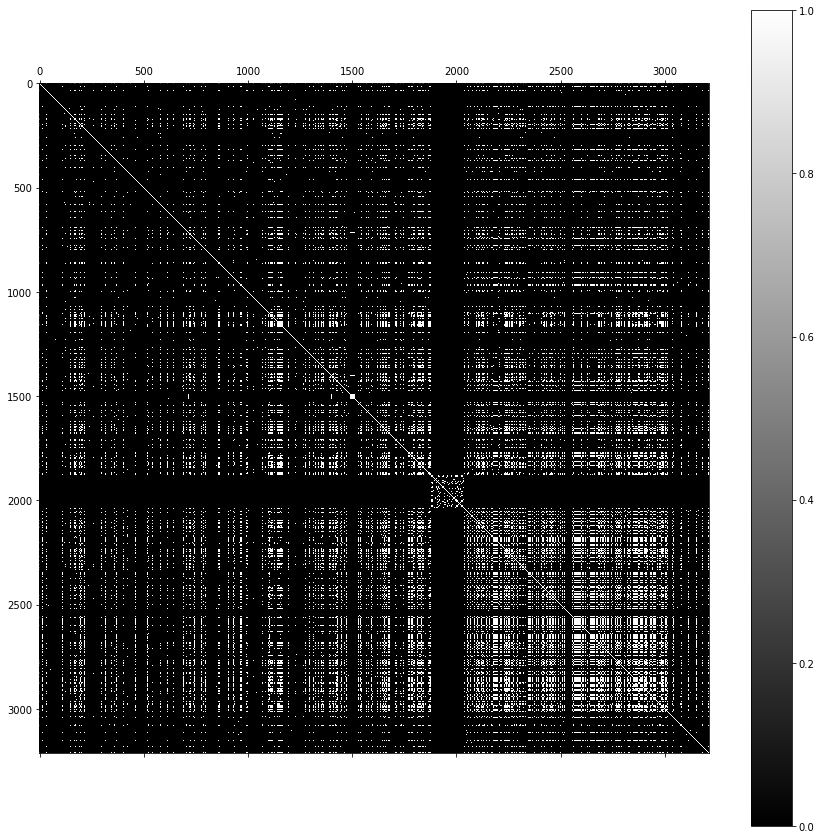

In [10]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", node_l=network_val.node_list))

# Plot measures on training and testing

In [12]:
import matplotlib.pyplot as plt
history = siamese.history
print(history.history.keys())
plt.figure(dpi=300)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
# plt.title('Link prediction performance')
plt.ylabel('AUC ROC score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

AttributeError: 'SiameseGraphEmbedding' object has no attribute 'history'

# Save Model

In [11]:
siamese.lstm_network.save("moge/data/LMN_Combined_NoCorr/models/lstm_512_nodes_randtrunc_weighted_e20.h5")

In [ ]:
siamese_net.summary()

In [ ]:
lstm_network.summary()

# Evaluate on test data

In [45]:
from moge.network.data_generator import DataGenerator
negative_sampling_ratio = 1.0
generator_Ed = DataGenerator(network=network_val, negative_sampling_ratio=negative_sampling_ratio,
                          maxlen=siamese.max_length, padding='post', truncating="post",
                          batch_size=siamese.batch_size, dim=siamese.input_shape, 
                          shuffle=True, seed=0)
generator_Ed.Eu_count = 0
generator_Ed.En_count = 0
generator_Ed.on_epoch_end()
# Ed_count: 72811 , Eu_count: 141062 , En_count: 130530, Ens_count: 145622
generator_Ed.Ed_count, generator_Ed.En_count, generator_Ed.Eu_count, generator_Ed.Ens_count

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: -28822
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 61491 , Eu_count: 0 , En_count: 0
Ens_count: 61491


(61491, 0, 0, 61491)

In [41]:
generator_Eu = DataGenerator(network=network_val, negative_sampling_ratio=negative_sampling_ratio,
                          maxlen=siamese.max_length, padding='post', truncating="post",
                          batch_size=siamese.batch_size, dim=siamese.input_shape, 
                          shuffle=True, seed=0)
generator_Eu.Ed_count = 0
generator_Eu.Ens_count = 0
generator_Eu.on_epoch_end()
generator_Eu.Ed_count, generator_Eu.En_count, generator_Eu.Eu_count, generator_Eu.Ens_count

Genes info columns: ['locus_type', 'location', 'Family', 'Transcript sequence', 'Disease association', 'Transcript length']
Number of nodes without seq removed: -30568
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 31779 , Eu_count: 11369 , En_count: 44750
Ens_count: 31779


(0, 44750, 11369, 0)

In [32]:
siamese.siamese_net.metrics_names

['loss', 'accuracy', 'precision', 'recall', 'auc_roc']

In [25]:
siamese.siamese_net.evaluate_generator(generator_Ed, use_multiprocessing=True, workers=8)

[0.2542295028765996,
 0.65888671875,
 0.9326468507448832,
 0.34162257313728334,
 0.9083935578664144]

In [43]:
siamese.siamese_net.evaluate_generator(generator_Eu, use_multiprocessing=True, workers=8)

[0.15404596810157484,
 0.8253455528846154,
 0.6789519236637995,
 0.25810594054368824,
 0.9377987017998328]

# Plot Precision-Recall Curve

In [164]:
# Get true labels
y_true = []
for i in range(len(generator_Ed)):
    _, y_i = generator_Ed.__getitem__(i)
    y_true.append(y_i)
y_true = np.vstack(y_true)
y_true = y_true.reshape((y_true.shape[0]))

# get predicted distances (need to convert to interaction probability)
y_pred = siamese.siamese_net.predict_generator(generator_Ed, use_multiprocessing=True, workers=8)
y_pred = y_pred.reshape((y_pred.shape[0]))

In [166]:
y_prob_pred = np.exp(-2.0 * y_pred)
np.average(y_prob_pred)

0.23939554

Text(0.5,1,'2-class Precision-Recall curve: AP=0.86')

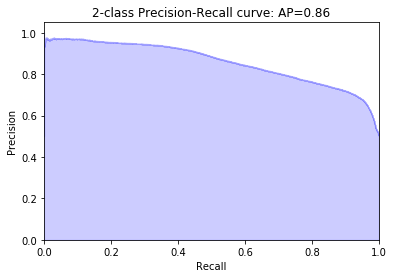

In [167]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_true, y_prob_pred)
precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_prob_pred, pos_label=1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

# AUC Rate

In [ ]:
%%javascript
Jupyter.notebook.session.delete();